In [14]:
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional
from keras.optimizers import SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import math
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [6]:
def plot_predictions(test, predicted):
    plt.plot(test, color="red", label="real IBM stock price")
    plt.plot(predicted, color="blue", label="predicted stock price")
    plt.title("IBM stock price prediction")
    plt.xlabel("time")
    plt.ylabel("IBM stock price")
    plt.legend()
    plt.show()

In [7]:
# function which calculates root mean squared error

def return_rmse(test, predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("the root mean squared error is : {}.".format(rmse))

In [10]:
data = pd.read_csv(r"C:\Users\sivar\Downloads\archive\IBM_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=["Date"])

data.shape

(3020, 6)

In [11]:
data.head(5)

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


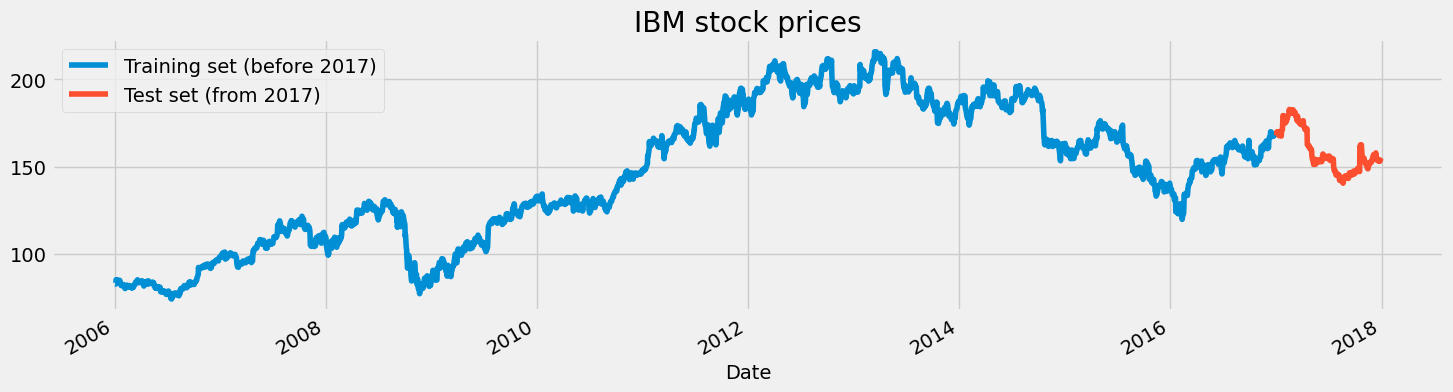

In [12]:
train = data[:'2016'].iloc[:,1:2].values
test = data['2017':].iloc[:,1:2].values

data["High"][:'2016'].plot(figsize=(16,4), legend=True)
data["High"]["2017":].plot(figsize=(16,4), legend=True)
plt.legend(["Training set (before 2017)", "Test set (from 2017)"])
plt.title("IBM stock prices")
plt.show()

In [16]:
# scaling the training set

sc = MinMaxScaler(feature_range=(0,1))
train_scaled = sc.fit_transform(train)

# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements

x_train = []
y_train = []

for i in range(60,2769):
    x_train.append(train_scaled[i-60:i, 0])
    y_train.append(train_scaled[i,0])

x_train, y_train = np.array(x_train), np.array(y_train)

In [17]:
x_train[0]


array([0.06065089, 0.06029868, 0.06311637, 0.0781206 , 0.07262609,
       0.07171034, 0.07657087, 0.07058326, 0.0669907 , 0.06494787,
       0.075796  , 0.07361229, 0.06417301, 0.05621302, 0.05783319,
       0.05409975, 0.05431107, 0.05515638, 0.05543815, 0.05677656,
       0.05846717, 0.05388842, 0.04811214, 0.04233587, 0.04402649,
       0.0490279 , 0.04832347, 0.05297267, 0.05614258, 0.05290223,
       0.05325444, 0.04909834, 0.04994365, 0.04797126, 0.05431107,
       0.05212736, 0.04726684, 0.04895745, 0.04656241, 0.04839391,
       0.04416737, 0.0485348 , 0.04719639, 0.04825303, 0.05395886,
       0.05663567, 0.05853762, 0.05959425, 0.06375035, 0.06917442,
       0.06889265, 0.06670893, 0.06910397, 0.07783883, 0.07565511,
       0.07276698, 0.06889265, 0.0656523 , 0.06656805, 0.06769513])

In [18]:
# reshaping x_train for efficient modelling

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2709, 60, 1)

In [23]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))


# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 'High' attribute data for processing

dataset_total = pd.concat((data['High'][:'2016'], data['High']['2017':]), axis=0)
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total)-len(test)-60 : ].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs = sc.transform(inputs)
print(inputs.shape)



# preparing x_test

x_test = []
for i in range(60,311):
    x_test.append(inputs[i-60:i, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

(3020,)
(311,)
(311, 1)
(311, 1)


In [27]:
# compiling the model

regressorGRU.compile(optimizer=SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False), loss='mean_squared_error')

# fitting the model

regressorGRU.fit(x_train, y_train, epochs=5, batch_size=150)

Epoch 1/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.2014
Epoch 2/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0601
Epoch 3/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 0.0268
Epoch 4/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0056
Epoch 5/5
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0043


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


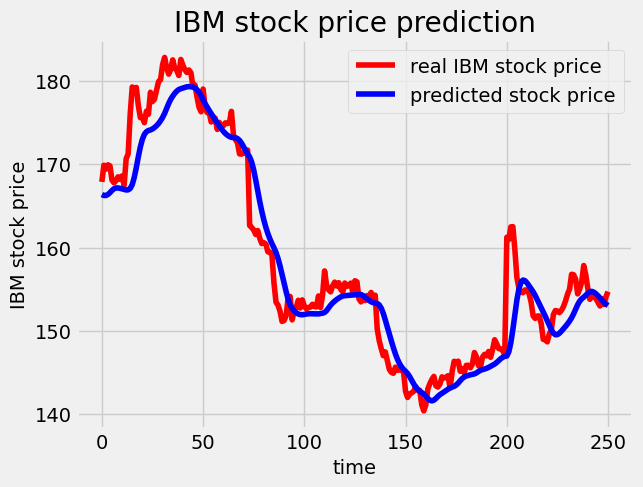

In [28]:
# predicting the stock prices for test set and visualization

predicted_with_gru = regressorGRU.predict(x_test)
predicted_with_gru = sc.inverse_transform(predicted_with_gru)

plot_predictions(test, predicted_with_gru)

In [29]:
# evaluating the model performance

return_rmse(test, predicted_with_gru)

the root mean squared error is : 3.358856308049329.
